# Spark ML для задачи оттока

Источник данных: [Kaggle](https://www.kaggle.com/sakshigoyal7/credit-card-customers)

Описания полей:

 | Название        | Описание                                                                                                                            |
 |:----------------|:------------------------------------------------------------------------------------------------------------------------------------|
 | CLIENTNUM       | Client number. Unique identifier for the customer holding the account                                                               |
 | Attrition_Flag  | Internal event (customer activity) variable                                                                                         |
 | Customer_Age    | Demographic variable - Customer's Age in Years                                                                                      |
 | Gender          | Demographic variable - M=Male, F=Female                                                                                             |
 | Dependent_count | Demographic variable - Number of dependents                                                                                         |
 | Education_Level | Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)               |
 | Marital_Status  | Demographic variable - Married, Single, Divorced, Unknown                                                                           |
 | Income_Category | Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown) |
 | Card_Category   | Product Variable - Type of Card (Blue, Silver, Gold, Platinum)                                                                      |
 | Months_on_book  | Period of relationship with bank                                                                                                    |

## Main Imports

In [1]:
from itertools import groupby
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Import pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

контекст исполнения `SparkSession` - необходим для начала работы со Spark

In [3]:
spark = SparkSession\
    .builder\
    .master("local[*]")\
    .appName("Spark ML Research")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/27 17:49:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Загрузка и знакомство с данными

In [4]:
raw = spark\
    .read\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .csv("data/BankChurners.csv")

### Убираем первую и последние две колонки
две последние - почему? - так написано в описании датасета автором.

первая - это ID клиента он не нужен для прогнозирования.

In [5]:
columns = raw.columns
# columnsLen = len(columns)
colsToDrop = columns[0].split() + columns[-2:]

df = raw.drop(*colsToDrop)

df.show(5, False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+--------

In [8]:
colsToDrop

['CLIENTNUM',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

In [9]:
# dataset shape
(len(df.columns), df.count())

(20, 10127)

### Определяем типы колонок

In [8]:
df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)


Так смотреть не удобно - отформатируем вывод

In [9]:
dt = df.dtypes
for r in dt:
    print(f"{r[0]:>25}\t{r[1]}")

           Attrition_Flag	string
             Customer_Age	int
                   Gender	string
          Dependent_count	int
          Education_Level	string
           Marital_Status	string
          Income_Category	string
            Card_Category	string
           Months_on_book	int
 Total_Relationship_Count	int
   Months_Inactive_12_mon	int
    Contacts_Count_12_mon	int
             Credit_Limit	double
      Total_Revolving_Bal	int
          Avg_Open_To_Buy	double
     Total_Amt_Chng_Q4_Q1	double
          Total_Trans_Amt	int
           Total_Trans_Ct	int
      Total_Ct_Chng_Q4_Q1	double
    Avg_Utilization_Ratio	double


Соберем по типам

In [10]:
dt.sort(key=lambda x: x[1])

for k, g in groupby(dt, lambda x: x[1]):
    print(f'Type of data {k:<6} - {len(list(g))}')

Type of data double - 5
Type of data int    - 9
Type of data string - 6


## Предобработка

### Проверим числовые колонки

In [10]:
numericColumns = list(
    map(lambda x: x[0], 
        filter(lambda x: x[1] == "double" or x[1] == "int", 
                df.dtypes)))

numericColumns

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [11]:
[s[0] for s in df.dtypes if s[1] in ["double", "int"]]

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [12]:
df.select(*numericColumns).summary().show()

23/11/27 18:04:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+---------------------+
|summary|     Customer_Age|   Dependent_count|    Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|     Credit_Limit|Total_Revolving_Bal|  Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|  Total_Trans_Amt|   Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-------+-----------------+------------------+------------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+---------------------+
|  count|            10127|             10127|             10127|                   10127|                 10127|              

In [19]:
df.select(*numericColumns).summary().show(1)

+-------+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|summary|Customer_Age|Dependent_count|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-------+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|  count|       10127|          10127|         10127|                   10127|                 10127|                10127|       10127|              10127|          10127|               10127|      

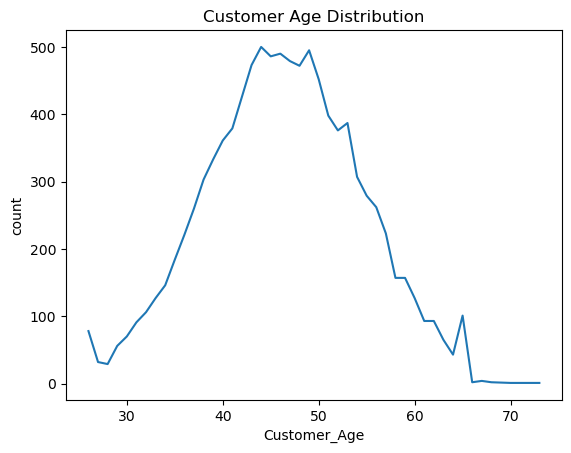

In [20]:
import matplotlib.pyplot as plt

age = df.groupBy("Customer_Age").count().orderBy("Customer_Age")
x_val = [val["Customer_Age"] for val in age.select("Customer_Age").collect()]
y_val = [val["count"] for val in age.select("count").collect()]

plt.plot(x_val, y_val)

plt.xlabel("Customer_Age")
plt.ylabel("count")
plt.title("Customer Age Distribution")

plt.show()

## Целевая колонка

In [24]:
df.groupBy("Attrition_Flag").count().show()

+-----------------+-----+
|   Attrition_Flag|count|
+-----------------+-----+
|Existing Customer| 8500|
|Attrited Customer| 1627|
+-----------------+-----+



In [25]:
# convert  target to Bool
dft = df\
    .withColumn("target", 
                f.when(df["Attrition_Flag"] == "Existing Customer",
                        0).otherwise(1))

dft.select("Attrition_Flag", "target").show(5, False)

+-----------------+------+
|Attrition_Flag   |target|
+-----------------+------+
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
+-----------------+------+
only showing top 5 rows



### Проверка сбалансированности данных

In [26]:
dft.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 1627|
|     0| 8500|
+------+-----+



### Oversampling

In [27]:
df1 = dft.filter(dft["target"] == 1)
df0 = dft.filter(dft["target"] == 0)

df1count = df1.count()
df0count = df0.count()

int(df0count / df1count)

5

In [28]:
# explode - разворачивает массив в отдельные строки, остальные строки копирует
# т.е колонка dummy будет содержать числа от 0 до 4 а остальные столбцы датафрейма остануться прежними. Т.е мы продублируем датафрейм столько раз.

df1Over = df1\
    .withColumn("dummy", 
                f.explode(
                    f.array(*[f.lit(x)
                                for x in range(int(df0count / df1count))])))\
    .drop("dummy")

df1Over.show(10, False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+---------

In [29]:
data = df0.unionAll(df1Over)
data.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     0| 8500|
|     1| 8135|
+------+-----+



### Проверим корреляции числовых признаков

#### Вариант 1: DataFrameStatFunctions

In [30]:
from itertools import combinations

# собираем пары для расчета корреляции
numericColumnsPairs = list(combinations(numericColumns, 2))
numericColumnsPairs

[('Customer_Age', 'Dependent_count'),
 ('Customer_Age', 'Months_on_book'),
 ('Customer_Age', 'Total_Relationship_Count'),
 ('Customer_Age', 'Months_Inactive_12_mon'),
 ('Customer_Age', 'Contacts_Count_12_mon'),
 ('Customer_Age', 'Credit_Limit'),
 ('Customer_Age', 'Total_Revolving_Bal'),
 ('Customer_Age', 'Avg_Open_To_Buy'),
 ('Customer_Age', 'Total_Amt_Chng_Q4_Q1'),
 ('Customer_Age', 'Total_Trans_Amt'),
 ('Customer_Age', 'Total_Trans_Ct'),
 ('Customer_Age', 'Total_Ct_Chng_Q4_Q1'),
 ('Customer_Age', 'Avg_Utilization_Ratio'),
 ('Dependent_count', 'Months_on_book'),
 ('Dependent_count', 'Total_Relationship_Count'),
 ('Dependent_count', 'Months_Inactive_12_mon'),
 ('Dependent_count', 'Contacts_Count_12_mon'),
 ('Dependent_count', 'Credit_Limit'),
 ('Dependent_count', 'Total_Revolving_Bal'),
 ('Dependent_count', 'Avg_Open_To_Buy'),
 ('Dependent_count', 'Total_Amt_Chng_Q4_Q1'),
 ('Dependent_count', 'Total_Trans_Amt'),
 ('Dependent_count', 'Total_Trans_Ct'),
 ('Dependent_count', 'Total_Ct_Chn

In [31]:
# data.stat.corr(x[0], x[1]) - считает корреляцию между двумя колонками в датафрейме

corr = list(
    filter(
        lambda x: abs(x[2]) > 0.6, 
        map(lambda x: (x[1], x[0], data.stat.corr(x[1], x[0])), numericColumnsPairs)))

In [32]:
# Выводим корреляцию 
corr.sort(key=lambda x: x[2])
for i in reversed(corr):
    print(f"{i[0]:>25} {i[1]:>25}\t{i[2]}")

          Avg_Open_To_Buy              Credit_Limit	0.9952040726156252
           Total_Trans_Ct           Total_Trans_Amt	0.8053901681243807
           Months_on_book              Customer_Age	0.7805047706891141
    Avg_Utilization_Ratio       Total_Revolving_Bal	0.6946855441968229


#### Вариант 2: Correlation

In [33]:
numericColumnsPairsFull = list(map(lambda z: z[1], map(lambda x: [x, list(map(lambda y: (x, y), numericColumns))], numericColumns)))
numericColumnsPairsFull

[[('Customer_Age', 'Customer_Age'),
  ('Customer_Age', 'Dependent_count'),
  ('Customer_Age', 'Months_on_book'),
  ('Customer_Age', 'Total_Relationship_Count'),
  ('Customer_Age', 'Months_Inactive_12_mon'),
  ('Customer_Age', 'Contacts_Count_12_mon'),
  ('Customer_Age', 'Credit_Limit'),
  ('Customer_Age', 'Total_Revolving_Bal'),
  ('Customer_Age', 'Avg_Open_To_Buy'),
  ('Customer_Age', 'Total_Amt_Chng_Q4_Q1'),
  ('Customer_Age', 'Total_Trans_Amt'),
  ('Customer_Age', 'Total_Trans_Ct'),
  ('Customer_Age', 'Total_Ct_Chng_Q4_Q1'),
  ('Customer_Age', 'Avg_Utilization_Ratio')],
 [('Dependent_count', 'Customer_Age'),
  ('Dependent_count', 'Dependent_count'),
  ('Dependent_count', 'Months_on_book'),
  ('Dependent_count', 'Total_Relationship_Count'),
  ('Dependent_count', 'Months_Inactive_12_mon'),
  ('Dependent_count', 'Contacts_Count_12_mon'),
  ('Dependent_count', 'Credit_Limit'),
  ('Dependent_count', 'Total_Revolving_Bal'),
  ('Dependent_count', 'Avg_Open_To_Buy'),
  ('Dependent_count', '

В Spark мы создаем объект трансформатор которому передаем __вектор__ содержащий числовые столбцы для вычисления корреляции

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# вектор с названиями числовых признаков
numericAssembler = VectorAssembler()\
    .setInputCols(numericColumns)\
    .setOutputCol("features")

# вычисляем корреляцию
numeric = numericAssembler.transform(data)
matrix = Correlation.corr(numeric, "features").head().asDict()['pearson(features)'].toArray().tolist()

23/11/27 19:09:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/27 19:09:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Обратите внимание на время расчета. Это на маленьком датафрейме!

In [35]:
numeric.select("features").show(5, False)

+-------------------------------------------------------------------------------+
|features                                                                       |
+-------------------------------------------------------------------------------+
|[45.0,3.0,39.0,5.0,1.0,3.0,12691.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061]|
|[49.0,5.0,44.0,6.0,1.0,2.0,8256.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105]  |
|[51.0,3.0,36.0,4.0,1.0,0.0,3418.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.0]      |
|[40.0,4.0,34.0,3.0,4.0,1.0,3313.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.76]   |
|[40.0,3.0,21.0,5.0,1.0,0.0,4716.0,0.0,4716.0,2.175,816.0,28.0,2.5,0.0]         |
+-------------------------------------------------------------------------------+
only showing top 5 rows



In [36]:
# собственно матрица корреляций
matrix

[[1.0,
  -0.13575515707704905,
  0.780504770689084,
  -0.026525310066417403,
  0.13116552936201348,
  -0.019944405497176732,
  0.016657097778483475,
  -0.002841536593767456,
  0.016929170875654043,
  -0.020559135165498028,
  -0.06586475313340744,
  -0.07815083273365253,
  -0.016568818333932693,
  -0.010985827540562288],
 [-0.13575515707704905,
  1.0,
  -0.11728062823959522,
  -0.03266417786351196,
  -0.010657501150598976,
  -0.02566496168277401,
  0.06002070339266479,
  0.0018723592997836101,
  0.05981512203616065,
  -0.04794367154504479,
  0.00700430540503166,
  0.025513406218718206,
  -0.019666216088456825,
  -0.03300255953641679],
 [0.780504770689084,
  -0.11728062823959522,
  1.0,
  -0.017395648588812672,
  0.17573226369307368,
  -0.018581210990133486,
  0.01736017181943523,
  0.002027784037740437,
  0.017155177760641748,
  -0.016079093535360012,
  -0.05568529445298156,
  -0.05906597721356735,
  -0.021148786215887182,
  -0.018757073876222614],
 [-0.026525310066417403,
  -0.03266417

Представим в читаемом виде для отбора признаков

In [37]:
# генерируем пары признаков для отображения корреляции между ними
def generate_cor_pairs(m, n):
    for x in range(0, len(m)):
        for y in range(0, len(m[0])):
            yield abs(matrix[x][y]), n[x][y]
            
cor_pairs = list(generate_cor_pairs(matrix, numericColumnsPairsFull))

In [38]:
# Фильтруем корреляцию по порогу 0.6 и убираем дубли (поскольку у нас целая матрица, а не треугольник)
corr2 = list(
    set(
        map(lambda x: (x[1][0], x[1][1], x[0]) if x[1][0] < x[1][1] else (x[1][1], x[1][0], x[0]),
            (filter(lambda x: 0.6 < x[0] < 1, cor_pairs)))))

In [39]:
# выводим пары признаков с корреляцией вторым методом
corr2.sort(key=lambda x: x[2])
for i in reversed(corr2):
    print(f"{i[0]:>25} {i[1]:>25}\t{i[2]}")

          Avg_Open_To_Buy              Credit_Limit	0.9952040726156179
          Total_Trans_Amt            Total_Trans_Ct	0.8053901681243786
             Customer_Age            Months_on_book	0.780504770689084
    Avg_Utilization_Ratio       Total_Revolving_Bal	0.6946855441968222


In [40]:
# выводим пары признаков с корреляцией первым методом
corr.sort(key=lambda x: x[2])
for i in reversed(corr):
    print(f"{i[0]:>25} {i[1]:>25}\t{i[2]}")

          Avg_Open_To_Buy              Credit_Limit	0.9952040726156252
           Total_Trans_Ct           Total_Trans_Amt	0.8053901681243807
           Months_on_book              Customer_Age	0.7805047706891141
    Avg_Utilization_Ratio       Total_Revolving_Bal	0.6946855441968229


#### Оставляем числовые колонки с низкой кореляцией

In [41]:
numericColumnsFinal = list(
    set(numericColumns) - set(map(lambda x: x[1], corr)))

numericColumnsFinal

['Avg_Open_To_Buy',
 'Total_Ct_Chng_Q4_Q1',
 'Dependent_count',
 'Total_Trans_Ct',
 'Contacts_Count_12_mon',
 'Avg_Utilization_Ratio',
 'Months_Inactive_12_mon',
 'Months_on_book',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Relationship_Count']

### Категориальные признаки

Документация нам сообщает, что сразу строковые данные на кодирование OneHotEncoder подать нельзя, поэтому сначала проиндексируем их и уже потом применим OneHotEncoder.

https://spark.apache.org/docs/latest/ml-features.html#onehotencoder 

#### Индексируем строковые колонки

In [42]:
# Преобразуем строки в числа - индексируем
from pyspark.ml.feature import StringIndexer


# убираем Attrition_Flag - это наш таргет
stringColumns = list(
    filter(
        lambda x: x != "Attrition_Flag",
        map(lambda x: x[0], 
            filter(lambda x: x[1] == "string", data.dtypes))))

# формируем названия выходных колонок
stringColumnsIndexed = list(map(lambda x: x + "_Indexed", stringColumns))

# передаем в трансформер список входных столбцов и список выходных столбцов
indexer = StringIndexer()\
    .setInputCols(stringColumns)\
    .setOutputCols(stringColumnsIndexed)

# корелятор вычислял сразу transforn, а здесь поскольку ему сначала нужно понимат ьсколько категорий у него будет прежде чем работать
# он вызывает сначала fit - смотрит сколько категорий будет и потом уже выполняет преобразование
# подробнее в документации https://spark.apache.org/docs/latest/ml-features.html#stringindexer 
indexed = indexer.fit(data).transform(data)
indexed.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|Gender_Indexed|Education_Level_Indexed|Marital_Status_Indexed|Income_Category_Indexed|Card_Category_Indexed|
+-----------------+------------+------+---------------+---------------+---------

#### Кодируем категориальные признаки

In [43]:
from pyspark.ml.feature import OneHotEncoder

# формируем названия выходных столбцов
catColumns = list(map(lambda x: x + "_Coded", stringColumnsIndexed))

# формируем трансформер с входными и выходными столбцами
# на выходе он выдаст "разреженный вектор" (a, b, c)
# a - количество элементов в векторе
# b - индексы ненулевых элементов
# с - значения
encoder = OneHotEncoder()\
    .setInputCols(stringColumnsIndexed)\
    .setOutputCols(catColumns)



# Запускаем преобразование
encoded = encoder.fit(indexed).transform(indexed)
encoded.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|Gender_Indexed|Education_Level_Indexed|Marital_Stat

### Собираем признаки в вектор

In [44]:
from pyspark.ml.feature import VectorAssembler

# собираем числовые и закодированные признаки
featureColumns = numericColumnsFinal + catColumns

# передаем в трансформер
assembler = VectorAssembler()\
    .setInputCols(featureColumns)\
    .setOutputCol("features")

# запускаем преобразование
assembled = assembler.transform(encoded)
assembled.show(5, truncate=False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+------------------------------------------------------------------------------------------------------------------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|

In [45]:
featureColumns

['Avg_Open_To_Buy',
 'Total_Ct_Chng_Q4_Q1',
 'Dependent_count',
 'Total_Trans_Ct',
 'Contacts_Count_12_mon',
 'Avg_Utilization_Ratio',
 'Months_Inactive_12_mon',
 'Months_on_book',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Relationship_Count',
 'Gender_Indexed_Coded',
 'Education_Level_Indexed_Coded',
 'Marital_Status_Indexed_Coded',
 'Income_Category_Indexed_Coded',
 'Card_Category_Indexed_Coded']

In [46]:
assembled.select("features").show(5, False)

+------------------------------------------------------------------------------------------------------------------+
|features                                                                                                          |
+------------------------------------------------------------------------------------------------------------------+
|(28,[0,1,2,3,4,5,6,7,8,9,12,17,23,25],[11914.0,1.625,3.0,42.0,3.0,0.061,1.0,39.0,1.335,5.0,1.0,1.0,1.0,1.0])      |
|(28,[0,1,2,3,4,5,6,7,8,9,10,11,18,20,25],[7392.0,3.714,5.0,33.0,2.0,0.105,1.0,44.0,1.541,6.0,1.0,1.0,1.0,1.0,1.0])|
|(28,[0,1,2,3,6,7,8,9,11,17,22,25],[3418.0,2.333,3.0,20.0,1.0,36.0,2.594,4.0,1.0,1.0,1.0,1.0])                     |
|(28,[0,1,2,3,4,5,6,7,8,9,10,12,19,20,25],[796.0,2.333,4.0,20.0,1.0,0.76,4.0,34.0,1.405,3.0,1.0,1.0,1.0,1.0,1.0])  |
|(28,[0,1,2,3,6,7,8,9,14,17,23,25],[4716.0,2.5,3.0,28.0,1.0,21.0,2.175,5.0,1.0,1.0,1.0,1.0])                       |
+---------------------------------------------------------------

### Нормализация

In [47]:
from pyspark.ml.feature import MinMaxScaler

# формируем трансформер, передаем входные и выходные столбцы 
scaler = MinMaxScaler()\
    .setInputCol("features")\
    .setOutputCol("scaledFeatures")

# преобразовываем
scaled = scaler.fit(assembled).transform(assembled)

# отображаем что получилось
scaled.select("features", "scaledFeatures").show(5, False)

+------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                          |scaledFeatures                                                                                                                                                                                                                     |
+------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Feature Selection (отбор признаков)

In [48]:
from pyspark.ml.feature import UnivariateFeatureSelector

selector = UnivariateFeatureSelector()\
    .setFeatureType("continuous")\
    .setLabelType("categorical")\
    .setSelectionMode("percentile")\
    .setSelectionThreshold(0.75)\
    .setFeaturesCol("scaledFeatures")\
    .setLabelCol("target")\
    .setOutputCol("selectedFeatures")

dataF = selector.fit(scaled).transform(scaled)

dataF.select("scaledFeatures", "selectedFeatures").show(5, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                                                                                                                                                     |selectedFeatures                                                                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------------------

## Моделирование

### Обучающая и тестовая выборки

In [49]:
tt = dataF.randomSplit([0.7, 0.3])
training = tt[0]
test = tt[1]

In [50]:
print(f"training\t{training.count():>5}\ntest    \t{test.count():>5}")

training	11706
test    	 4929


### Логистическая регрессия

In [51]:
from pyspark.ml.classification import LogisticRegression

# создаем трансфомер
lr = LogisticRegression()\
    .setMaxIter(1000)\
    .setRegParam(0.2)\
    .setElasticNetParam(0.8)\
    .setFamily("binomial")\
    .setFeaturesCol("selectedFeatures")\
    .setLabelCol("target")

# вызываем его на данные и сохраняем в новый датафрейм
lrModel = lr.fit(training)

print(f"Coefficients: {lrModel.coefficients}\nIntercept: {lrModel.intercept}")

Coefficients: (21,[0,2],[-0.23774982104223344,-2.0798677181517493])
Intercept: 0.7435821829230623


### Training Summary

In [52]:
trainingSummary = lrModel.summary

print(f"accuracy: {trainingSummary.accuracy}")
print(f"areaUnderROC: {trainingSummary.areaUnderROC}")

accuracy: 0.7729369554074833
areaUnderROC: 0.8031358261621421


### Проверяем модель на тестовой выборке

In [53]:
predicted = lrModel.transform(test)

predicted.select("target", "prediction").show(10, False)

+------+----------+
|target|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|0     |1.0       |
|0     |0.0       |
|0     |1.0       |
|0     |1.0       |
|0     |1.0       |
|0     |0.0       |
|0     |1.0       |
|0     |1.0       |
+------+----------+
only showing top 10 rows



In [54]:
predicted.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt

! Искать эвалюаторы нужно в разделе подбора гиперпараметров и дальше там рыться

In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setLabelCol("target")

print(f"areaUnderROC: {evaluator.evaluate(predicted)}")

areaUnderROC: 0.79480436826618


#### Confusion Matrix (матрица ошибок)

* True Positive (TP) - label is positive and prediction is also positive
* True Negative (TN) - label is negative and prediction is also negative
* False Positive (FP) - label is negative but prediction is positive
* False Negative (FN) - label is positive but prediction is negative

К сожалению в настоящий момент в Spark нет инструмента для автоматического вычисления матрицы ошибок (ну или я их не знаю)

In [56]:
tp = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 1)).count()
tn = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 0)).count()
fp = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 1)).count()
fn = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 0)).count()

print(f"Confusion Matrix :\n{tp:>4}\t{fp:>4}\n{fn:>4}\t{tn:>4}")

Confusion Matrix :
1893	 615
 542	1879


#### Accuracy, Precision, Recall

* Accuracy (доля правильных ответов) = TP + TN / TP + TN + FP + FN
* Precision (точность) = TP / TP + FP
* Recall (полнота) = TP / TP + FN

In [57]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Accuracy = {accuracy:1.4f}")
print(f"Precision = {precision:1.4f}")
print(f"Recall = {recall:1.4f}")

Accuracy = 0.7653
Precision = 0.7548
Recall = 0.7774


## Настраиваем модель (подбираем гиперпараметры)

_`CrossValidation` от Spark работате не очень шустро и сильно грузит процессор_

In [58]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.01, 0.1, 0.5])\
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

trainValidationSplit = TrainValidationSplit()\
    .setEstimator(lr)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(paramGrid)\
    .setTrainRatio(0.7)\
    .setParallelism(2)

model = trainValidationSplit.fit(dataF)

In [59]:
param_map = model.bestModel.extractParamMap()
for i in param_map:
    print(f"{i.name:<16}\t{param_map[i]}")

aggregationDepth	2
elasticNetParam 	0.0
family          	binomial
featuresCol     	selectedFeatures
fitIntercept    	True
labelCol        	target
maxBlockSizeInMB	0.0
maxIter         	1000
predictionCol   	prediction
probabilityCol  	probability
rawPredictionCol	rawPrediction
regParam        	0.01
standardization 	True
threshold       	0.5
tol             	1e-06


In [61]:
from pyspark.ml.tuning import CrossValidator

cv = CrossValidator(
    estimator=lr, 
    estimatorParamMaps=paramGrid, 
    evaluator=evaluator,
    parallelism=8
    )

cvModel = cv.fit(dataF)

In [62]:
param_cv_map = cvModel.bestModel.extractParamMap()
for i in param_cv_map:
    print(f"{i.name:<16}\t{param_cv_map[i]:<16}\t{param_map[i]}")

aggregationDepth	2               	2
elasticNetParam 	0.0             	0.0
family          	binomial        	binomial
featuresCol     	selectedFeatures	selectedFeatures
fitIntercept    	1               	True
labelCol        	target          	target
maxBlockSizeInMB	0.0             	0.0
maxIter         	1000            	1000
predictionCol   	prediction      	prediction
probabilityCol  	probability     	probability
rawPredictionCol	rawPrediction   	rawPrediction
regParam        	0.01            	0.01
standardization 	1               	True
threshold       	0.5             	0.5
tol             	1e-06           	1e-06


In [63]:
type(model)

pyspark.ml.tuning.TrainValidationSplitModel

In [64]:
bestML = model.bestModel

## Собираем всё вместе (Pipeline)

1. Отобрали числовые признаки:numericColumnsFinal
2. Проиндексировали строковые признаки: __indexer__
3. Закодировали категориальные признаки: __encoder__
4. Собрали признаки в вектор: __assembler__
5. Нормализовали признаки: __scaler__
6. Провели отбор признаков: __selector__
7. Рассчитали модель: __bestML__

In [65]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(
    [indexer, encoder, assembler, scaler, selector, bestML])

In [66]:
type(indexer)

pyspark.ml.feature.StringIndexer

In [67]:
[trainingData, testData] = data.randomSplit([0.7, 0.3], seed=42)

pipelineModel = pipeline.fit(trainingData)

## Сохраняем модель

In [68]:
pipelineModel.write().overwrite().save("pipelineModel")

23/11/28 07:31:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 900901 ms exceeds timeout 120000 ms
23/11/28 07:31:47 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/28 07:31:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B